# Algorithm Comparison
Throughout the development of conditional entropy forests, we have come with multiple iterations of the algorithm. Each iteration led to a better and more consistent estimate of condtitional entropy for categorical data. We will show how algorithm changes such as honesty and robust finite sampling impact our algorithm starting with just using CART.

## Sampling Code

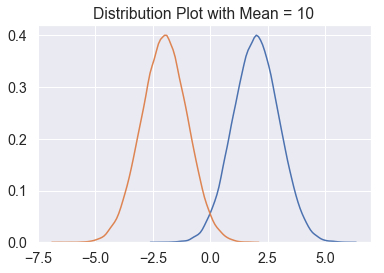

In [9]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100000, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False)
sns.distplot(list(zip(*class_neg_one))[0], hist=False)
plt.title("Distribution Plot with Mean = 10")
plt.show()

## CART Estimate
First iteration, just using CART random forests. We retrieve conditional distribution estimate from the in bag samples. This causes serious overfitting problems.

In [60]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from scipy.stats import entropy

def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

X, y = get_sample(5000, 1, 1)
CART_estimate(np.array(X).reshape(-1, 1), y, 300)

0.1669550035399436

In [46]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(5000, 1, 1)
X = np.array(X).reshape(-1, 1)

def OOB_estimate(X, y, n_estimators = 300, max_samples = .63, bootstrap = True, depth = 30):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        #print(node_counts)
        #print(X[unsampled_indices])
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        #print(partition_counts)
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

OOB_estimate(X, y, 300, .63)

0.15413685727858045

In [49]:
def honesty_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))

        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')
X, y = get_sample(5000, 1, 1)
X = np.array(X).reshape(-1, 1)
honesty_estimate(X, y, 300, .32)


0.31018251325714663

In [54]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier


def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

X, y = get_sample(10000, 1, 1)
X = np.array(X).reshape(-1, 1)

cef_estimate(X, y, 300, .32)


0.3550943191815057

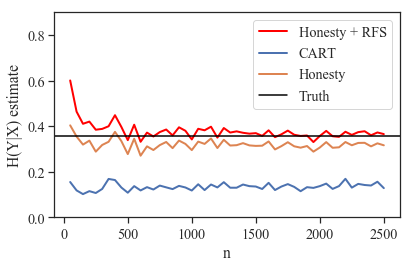

In [70]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    cef = []
    cart = []
    honest = []
    sample_sizes = [i*50 for i in range(1, 51)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        cef.append(cef_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        cart.append(CART_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        honest.append(honesty_estimate(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
    return sample_sizes, cef, cart, honest


#sample_sizes, cef, cart, honest = get_cond_entropy_vs_n(1)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.figure()
plt.rcParams["font.family"] = "Times New Roman"
sns.set

line_cef, = plt.plot(sample_sizes, cef, label = "Honesty + RFS", linewidth = 2, color = "red")
line_cart, = plt.plot(sample_sizes, cart, label = "CART", linewidth = 2)
line_honest, = plt.plot(sample_sizes, honest, label = "Honesty", linewidth = 2)
line_true = plt.axhline(y=.356,linestyle='-', color = "black", label = "Truth")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .9)
plt.legend(handles=[line_cef, line_cart, line_honest, line_true])
#plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.tight_layout()
plt.savefig("alg_comparison.png")
plt.show()
